### No Manipulation of Columns, Just Drop NAs

In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats
import warnings
import statsmodels.api as sm
from patsy import dmatrices

warnings.filterwarnings('ignore')

#reading input file
df_raw = pd.read_csv('/Users/vishwapatel/Desktop/MIS 381N - Data Science Programming/Group Project/Airbnb_Data.csv')

#dropping NA
df_raw = df_raw.dropna()


#amenities column - extracting top categories which occured in more than 5000 reviews
amenities_split = df_raw['amenities'].str.get_dummies(sep=',')
amenities_split.columns = amenities_split.columns.str.strip('{}').str.replace('"', '')
amenity_counts = amenities_split.sum()
frequent_amenities = amenity_counts[amenity_counts > 5000].index
amenities_filtered = amenities_split[frequent_amenities]
df_raw = df_raw.drop(columns=['amenities'])
df_raw = pd.concat([df_raw, amenities_filtered], axis=1)
df_raw = df_raw.loc[:, ~df_raw.columns.duplicated()]
df_raw = df_raw.drop(columns=['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50'])


#converting first_review and last_review to date
df_raw['first_review'] = pd.to_datetime(df_raw['first_review'], format='%Y-%m-%d')
df_raw['last_review'] = pd.to_datetime(df_raw['last_review'], format='%Y-%m-%d')

#calculating tenure of listing in days based on last_review and first_review
df_raw['Tenure_of_Listing'] = (df_raw['last_review'] - df_raw['first_review']).dt.days

#dropping unecessary columns
df_raw = df_raw.drop(columns=['first_review', 'last_review','name', 'thumbnail_url', 'description'])


df = df_raw
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True).str.lower() #removing special characters from column names
df.shape
#list(df.columns)


(38502, 53)

### Set Up Matrices

In [ ]:

#formula for dmatrices since there are so many column names. This makes it easier to switch out columns as needed.
formula = (
    'log_price ~ property_type + room_type + accommodates + bathrooms + bed_type + cancellation_policy + cleaning_fee + city + host_has_profile_pic + host_identity_verified  + host_response_rate + instant_bookable + latitude + longitude  + number_of_reviews + review_scores_rating + bedrooms + beds + tenure_of_listing + Q("24hourcheckin") + airconditioning + buzzerwirelessintercom + cabletv + carbonmonoxidedetector + familykidfriendly + fireextinguisher + firstaidkit + freeparkingonpremises + hairdryer + laptopfriendlyworkspace + lockonbedroomdoor + petsallowed + petsliveonthisproperty + safetycard + selfcheckin + smokedetector + wirelessinternet + dryer + elevator + essentials + hangers + heating + internet + iron + kitchen + zipcode + neighbourhood + host_since'
)
#tenure_of_listing

#split into test and train sets
y, X = dmatrices(formula,
                 data=df, return_type='dataframe')

y = y['log_price'].values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Create the Model and Print Results

In [ ]:
#set up the model with training data
model = sm.OLS(y_train, X_train)

#fit the model
result = model.fit()

#print the summary of the model
print(result.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     25.22
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:47:19   Log-Likelihood:                -6069.1
No. Observations:               30801   AIC:                         2.055e+04
Df Residuals:                   26595   BIC:                         5.561e+04
Df Model:                        4205                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

### Calculate Train and Test MSE/RMSE LOGGED

In [ ]:
import statistics
import math

#predict on the training set
y_pred_train = result.predict(X_train)

#predict on the test set
y_pred_test = result.predict(X_test)

#train MSE/RMSE
train_MSE = statistics.mean((y_pred_train - y_train)**2)
train_RMSE = math.sqrt(train_MSE)
print("train RMSE: ",train_RMSE)
print("train MSE: ", train_MSE)


#test MSE/RMSE
test_MSE = statistics.mean((y_pred_test - y_test)**2)
test_RMSE = math.sqrt(test_MSE)
print("test RMSE: ",test_RMSE)
print("test MSE: ", test_MSE)


train RMSE:  0.29467050571789793
train MSE:  0.0868307069400417
test RMSE:  0.3431727468403106
test MSE:  0.11776753417392391


### Calculate Train and Test MSE/RMSE EXPONENTIATED

In [ ]:
#predict on the training set
y_pred_train_exp = np.exp(y_pred_train)

#predict on the test set
y_pred_test_exp = np.exp(y_pred_test)

#train MSE/RMSE
train_MSE_exp = statistics.mean((y_pred_train_exp - np.exp(y_train))**2)
train_RMSE_exp = math.sqrt(train_MSE_exp)
print("train RMSE EXPONENTIATED: ",train_RMSE_exp)
print("train MSE EXPONENTIATED: ", train_MSE_exp)


#test MSE/RMSE
test_MSE_exp = statistics.mean((y_pred_test_exp - np.exp(y_test))**2)
test_RMSE_exp = math.sqrt(test_MSE_exp)
print("test RMSE EXPONENTIATED: ",test_RMSE_exp)
print("test MSE EXPONENTIATED: ", test_MSE_exp)

train RMSE EXPONENTIATED:  68.29496936421482
train MSE EXPONENTIATED:  4664.202840459041
test RMSE EXPONENTIATED:  80.45712159743528
test MSE EXPONENTIATED:  6473.348415744486


### Plot the Predicted Vs. Actual Test Values LOGGED

Text(0, 0.5, 'Predicted Log Price from Test Set')

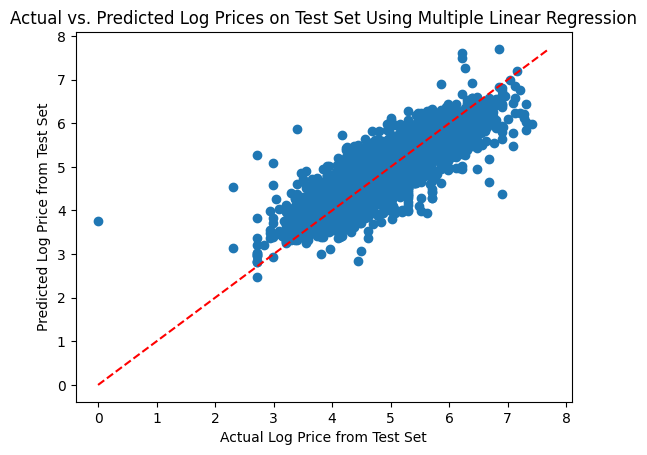

In [ ]:
plt.scatter(x=y_test, y=y_pred_test)

min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.title("Actual vs. Predicted Log Prices on Test Set Using Multiple Linear Regression")
plt.xlabel("Actual Log Price from Test Set")
plt.ylabel("Predicted Log Price from Test Set")

### Plot the Predicted Vs. Actual Test Values EXPONENTIATED

Text(0, 0.5, 'Predicted Price from Test Set')

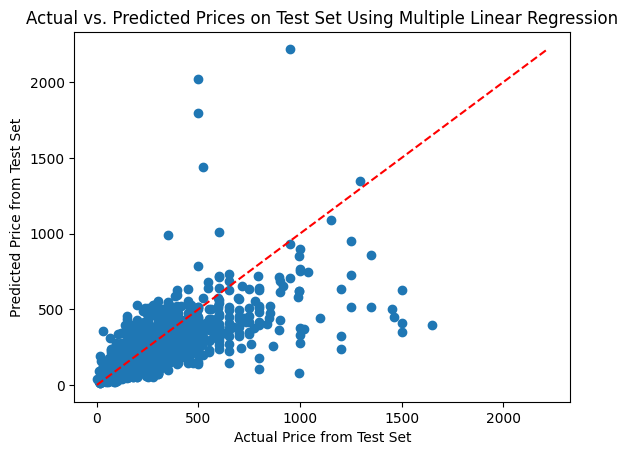

In [ ]:
plt.scatter(x=np.exp(y_test), y=y_pred_test_exp)

min_val = min(min(np.exp(y_test)), min(y_pred_test_exp))
max_val = max(max(np.exp(y_test)), max(y_pred_test_exp))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.title("Actual vs. Predicted Prices on Test Set Using Multiple Linear Regression")
plt.xlabel("Actual Price from Test Set")
plt.ylabel("Predicted Price from Test Set")

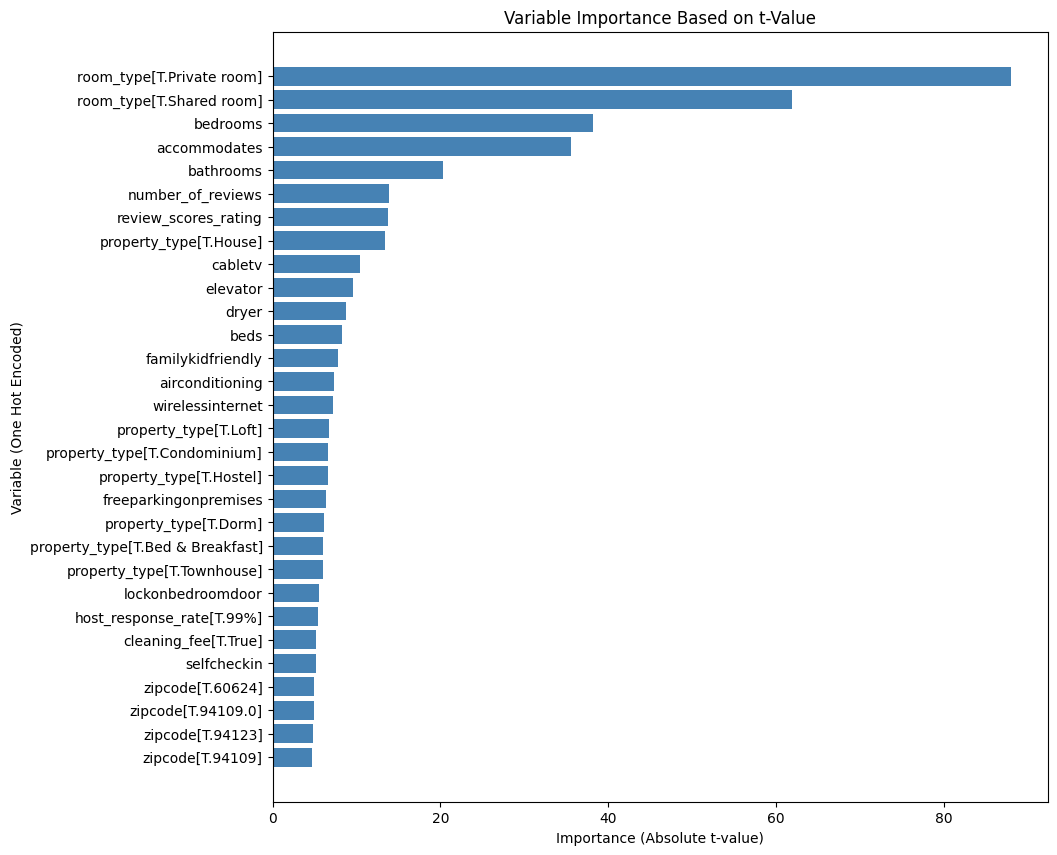

In [ ]:
# Assuming `model_summary` is the summary output from statsmodels
t_values = result.tvalues.abs()
variable_names = result.tvalues.index

# Create a DataFrame with variable names and their importance
importance_df = pd.DataFrame({
    'Variable': variable_names,
    'Importance': t_values
})

# Remove intercept from importance
importance_df = importance_df[importance_df['Variable'] != 'Intercept']

# Sort variables by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(30)

# Plot variable importance using matplotlib
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Variable'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance (Absolute t-value)')
plt.ylabel('Variable (One Hot Encoded)')
plt.title('Variable Importance Based on t-Value')
plt.gca().invert_yaxis()  # To have the most important variable at the top
plt.show()